In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go

In [7]:
# Load the dataset
data = pd.read_csv('twitter_cleaned_data.csv')

data = data.dropna()

# Step 1: Prepare the data
X = data['cleaned_data'].astype(str)  # Text data
y = data['category']  # Sentiment labels

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [10]:
print(X_train.shape)
print(X_test.shape)

(130314,)
(32579,)


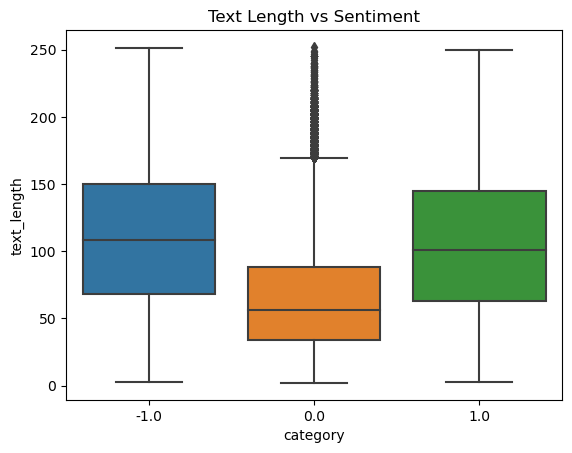

In [14]:
data['text_length'] = X.apply(len)
sns.boxplot(x='category', y='text_length', data=data)
plt.title('Text Length vs Sentiment')
plt.show()

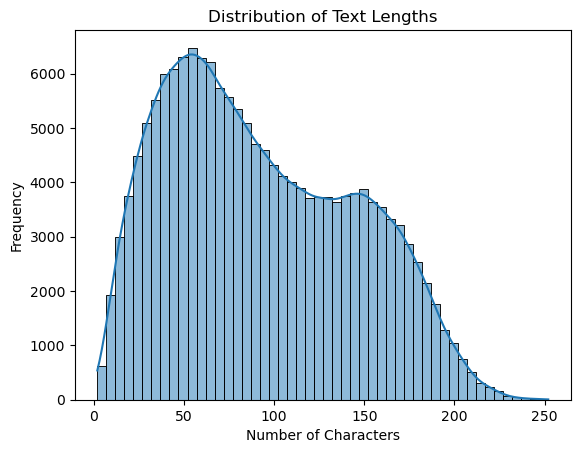

In [15]:
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [16]:
tfidf = TfidfVectorizer(max_features=50000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(130314, 50000)

In [17]:
sample_limit = 10000
X_train_sampled = X_train_tfidf[:sample_limit]
feature_array = np.array(tfidf.get_feature_names_out())
tfidf_means = np.mean(X_train_sampled.toarray(), axis=0)
tfidf_sorting = np.argsort(tfidf_means)[::-1]
top_words = feature_array[tfidf_sorting][:10]
print("Top 10 TF-IDF Words (Limited Samples):", top_words)

Top 10 TF-IDF Words (Limited Samples): ['modi' 'india' 'not' 'do' 'vote' 'say' 'bjp' 'people' 'narendra' 'give']


In [18]:
data = pd.DataFrame({
    'text': X,
    'sentiment': y
})

word_sentiment_counts = {word: {'positive': 0, 'negative': 0, 'neutral': 0} for word in top_words}

sentiment_map = {1: 'positive', 0: 'neutral', -1: 'negative'}

for index, row in data.iterrows():
    text = row['text']
    sentiment = row['sentiment']
    sentiment_category = sentiment_map[sentiment]
    for word in top_words:
        if word in text:
            word_sentiment_counts[word][sentiment_category] += 1

word_sentiment_df = pd.DataFrame(word_sentiment_counts).T.reset_index()
word_sentiment_df.columns = ['word', 'positive', 'negative', 'neutral']

print(word_sentiment_df)


       word  positive  negative  neutral
0      modi     66167     32881    49364
1     india     17287      7503     8255
2       not     10811      6349     5981
3        do     12704      6548     7150
4      vote      5455      2490     3551
5       say      6673      3700     4521
6       bjp      6591      3400     3960
7    people      6489      3731     2807
8  narendra      5467      1870     4022
9      give      5610      2827     2954


In [20]:
melted_df = word_sentiment_df.melt(id_vars='word', value_vars=['positive', 'negative', 'neutral'],
                                     var_name='sentiment', value_name='count')
fig = px.bar(melted_df, x='word', y='count', color='sentiment', barmode='group',
             title='Sentiment Association of Top TF-IDF Words')
fig.show()


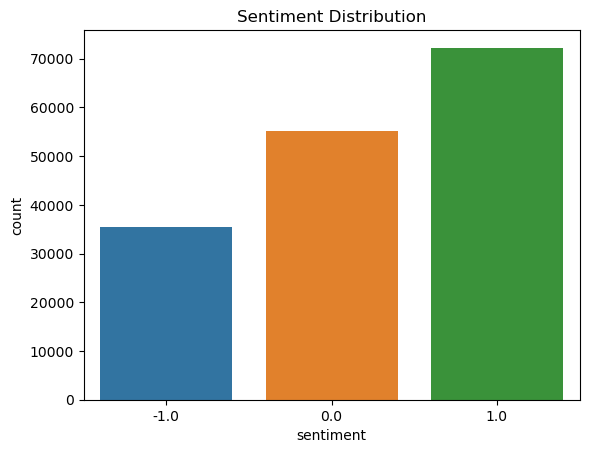

In [26]:
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.show()

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)



In [30]:
data.head()


,text,sentiment
0,modi promise minimum government maximum govern...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp tell rahul main camp...,1.0
3,ask supporter prefix chowkidar name modi great...,1.0
4,answer among powerful world leader today trump...,1.0


In [31]:
temp = pd.DataFrame(y_train_resampled, columns=['category'])
sentiment_counts = temp['category'].value_counts().reset_index()
sentiment_counts.columns = ['category', 'count']

fig = go.Figure(go.Funnelarea(
    text=sentiment_counts['category'],
    values=sentiment_counts['count'],
    title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))

fig.show()

In [34]:
# Step 4: Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000,class_weight='balanced')
lr_model.fit(X_train_resampled, y_train_resampled)

# Step 5: Make predictions and evaluate
y_pred = lr_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print(f"Logistic Regression TF-IDF Accuracy: {accuracy:.4f}")

Logistic Regression TF-IDF Accuracy: 0.8461


Classification Report:
              precision    recall  f1-score   support

        -1.0       0.77      0.80      0.78      7126
         0.0       0.83      0.91      0.87     10997
         1.0       0.90      0.82      0.86     14456

    accuracy                           0.85     32579
   macro avg       0.83      0.84      0.84     32579
weighted avg       0.85      0.85      0.85     32579



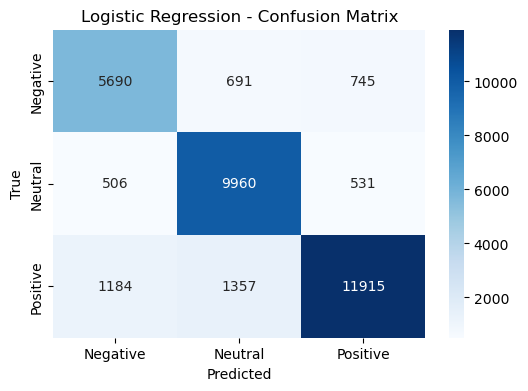

In [36]:
#Make predictions
y_pred = lr_model.predict(X_test_tfidf)

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()